In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-16 14:29:45.586442: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 14:29:45.599388: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 14:29:45.703578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 14:29:45.744354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744828185.809666  520533 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744828185.82

In [ ]:
train_df = pd.read_csv("../DATA/data/train.csv")

In [ ]:
# Load the test data
test_df = pd.read_csv("../DATA/data/label_test.csv")

In [ ]:
# For the train dataset
train_df['image_path'] = train_df['image_path'].apply(lambda x: 'DS-4002-CS/DATA/data/images/' + x.split('/')[-1])

# For the test dataset
test_df['image_path'] = test_df['image_path'].apply(lambda x: 'DS-4002-CS/DATA/data/images/' + x.split('/')[-1])


In [13]:
NUM_CLASSES = train_df['emergency_or_not'].nunique()
print(NUM_CLASSES)

2


In [27]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [28]:
train_df.head()

,image_names,emergency_or_not,image_path
0,1503.jpg,0,DS-4002-P3/data/data/images/1503.jpg
1,1420.jpg,0,DS-4002-P3/data/data/images/1420.jpg
2,1764.jpg,0,DS-4002-P3/data/data/images/1764.jpg
3,1356.jpg,0,DS-4002-P3/data/data/images/1356.jpg
4,1117.jpg,0,DS-4002-P3/data/data/images/1117.jpg


In [29]:
test_df.head()

,image_names,emergency_or_not,Unnamed: 2,image_path
0,1960.jpg,0,NaN,DS-4002-P3/data/data/images/1960.jpg
1,668.jpg,1,NaN,DS-4002-P3/data/data/images/668.jpg
2,2082.jpg,0,NaN,DS-4002-P3/data/data/images/2082.jpg
3,808.jpg,1,NaN,DS-4002-P3/data/data/images/808.jpg
4,1907.jpg,0,NaN,DS-4002-P3/data/data/images/1907.jpg


In [36]:
# Convert 'emergency_or_not' to strings
train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)
test_df['emergency_or_not'] = test_df['emergency_or_not'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='emergency_or_not',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='emergency_or_not',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='emergency_or_not',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False
)



Found 1317 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 706 validated image filenames belonging to 2 classes.


In [37]:

# Define number of classes for binary classification
NUM_CLASSES = 2  

# Load the ResNet50 model without the top layer and with ImageNet weights
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(224, 224, 3))
)

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x) 

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
history = model.fit(
    train_generator,
    epochs=10,  # Set the number of epochs
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


/home/qpv9hv/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/qpv9hv/.local/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_356']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


41/41 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6657 - loss: 0.7423 - val_accuracy: 0.9094 - val_loss: 0.2438
Epoch 2/10
 1/41 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8438 - loss: 0.2738

/home/qpv9hv/.local/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - accuracy: 0.8438 - loss: 0.2738 - val_accuracy: 0.8938 - val_loss: 0.2464
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8748 - loss: 0.3148 - val_accuracy: 0.9062 - val_loss: 0.2254
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - accuracy: 0.8438 - loss: 0.4077 - val_accuracy: 0.9156 - val_loss: 0.2089
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9080 - loss: 0.2520 - val_accuracy: 0.9219 - val_loss: 0.1760
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - accuracy: 0.8750 - loss: 0.2224 - val_accuracy: 0.9187 - val_loss: 0.1821
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9139 - loss: 0.2240 - val_accuracy: 0.9438 - val_loss: 0.1842
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 381ms/step - accuracy: 0.8438 - loss: 0.3419 - val_accuracy: 0.9281 - val_loss: 0.1971
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9254 - loss: 0.2201 - val_accuracy: 0.9312 - val_loss

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8917 - loss: 0.2882
Test Loss: 0.2678341567516327
Test Accuracy: 0.9034090638160706


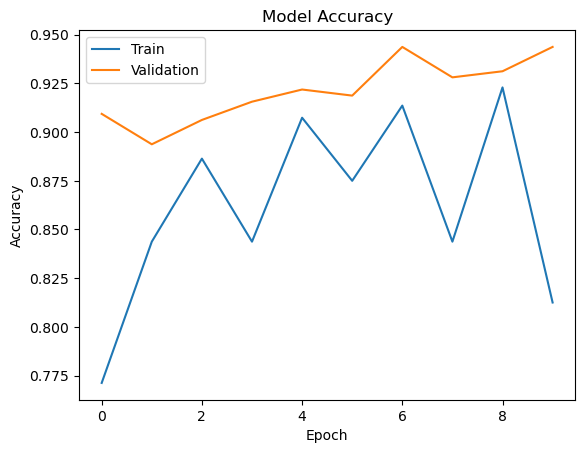

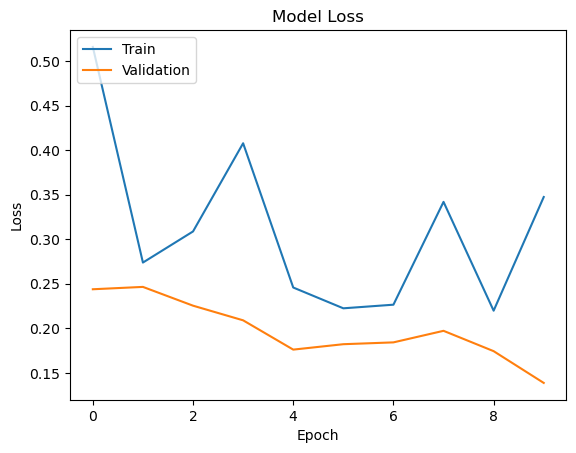

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save('my_model.keras')